# Imports

In [360]:
import pandas
import numpy
import seaborn
import matplotlib.pyplot as pyplot
from ipydatagrid import DataGrid
import re
import nltk
# from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer

 #nltk.download('punkt_tab')
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\dillo\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# Loading of Data

- Load the data using ANSI encoding to resolve encoding isses
- Exploratory data analysis
    - Row and column counts
    - Column names
    - Non-null counts
    - Check data types

In [361]:
# Load the raw data from the file
# file encoding is ANSI, used Notepad++ to look at UTF-8 encoding error
raw_df  = pandas.read_csv('SIS_Faculty-List.csv', encoding = 'ANSI', header = 0)

# Display the number of rows and columns
print(raw_df.shape)

# Display column names, non-null count and data type
raw_df.info()

# review the data
# Only 285 rows, so lets load everything into a grid
DataGrid(raw_df)  

# Some terrible column names, should simplify

(284, 19)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284 entries, 0 to 283
Data columns (total 19 columns):
 #   Column                                                                                                                         Non-Null Count  Dtype 
---  ------                                                                                                                         --------------  ----- 
 0   ID                                                                                                                             282 non-null    object
 1   Name                                                                                                                           284 non-null    object
 2   Location                                                                                                                       270 non-null    object
 3   Grade                                                                                                    

DataGrid(auto_fit_params={'area': 'all', 'padding': 30, 'numCols': None}, corner_renderer=None, default_render…

# Data Presence Checks

By looking at the data in the DataGrid, we can see quite a few issues in the data.
Lets dig a bit deeper

- Plot missing data
- Determine percentage of data missing from each column

In [362]:
# ID Columns seems to have weird data types and zero values
# Filter out rows where the substring 'LT' is not in the ID column
raw_df_id_filtered = raw_df[~raw_df['ID'].str.contains('LT', na=False)]
DataGrid(raw_df_id_filtered)

# This is problematic, suggestion is to drop the column as no obvioius way to create missing values

DataGrid(auto_fit_params={'area': 'all', 'padding': 30, 'numCols': None}, corner_renderer=None, default_render…

In [363]:
# Given the ID is not very useful, lets see if we have duplcate rows based on the name
duplicate_rows = raw_df[raw_df.duplicated(subset=['Name'], keep=False)]
DataGrid(duplicate_rows)

# These are not true duplicates, appear to be a Ralph Kimball "Type 2" attribute

DataGrid(auto_fit_params={'area': 'all', 'padding': 30, 'numCols': None}, corner_renderer=None, default_render…

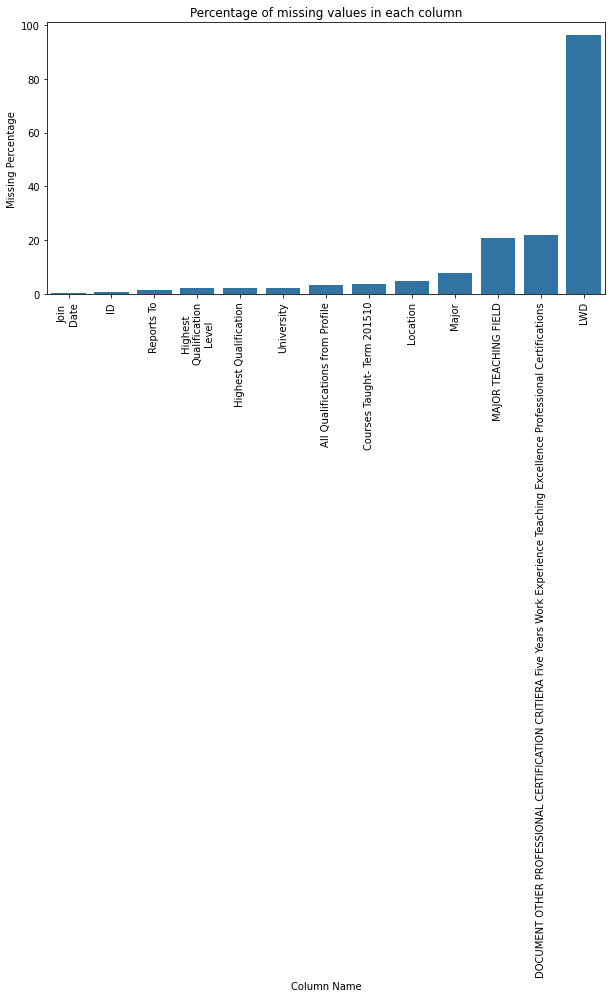

In [364]:
# Missing values per columns
# Missing values plot 
# Calculate the percentage of missing values in each column, only return columns with missing values
missing_column_values = raw_df.isnull().mean() * 100
missing_column_values = missing_column_values[missing_column_values > 0]
missing_column_values.sort_values(inplace=True)

# Create a dataframe to store the missing values and their percentage
missing_column_df = missing_column_values.to_frame()
missing_column_df.columns = ['Missing Percentage']
missing_column_df.index.names = ['Column Name']

# plot a barchart of total missing values in each column
pyplot.figure(figsize=(10, 5))
seaborn.barplot(x = 'Column Name', y = 'Missing Percentage', data=missing_column_df)
pyplot.title('Percentage of missing values in each column')
pyplot.xticks(rotation = 90)
pyplot.show()

# LWD is missing a lot of data
# LWD appears to stand for "Last Working Date"
# Data seems valid, however column name should be confirmed with the data steward

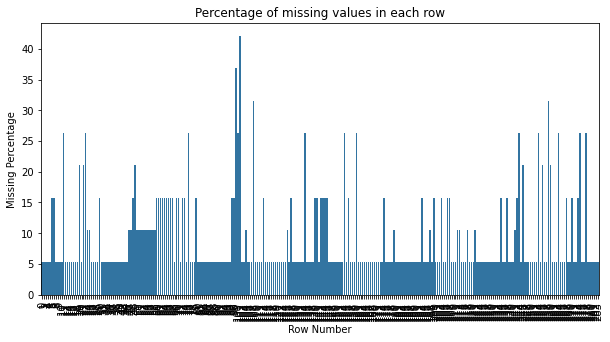

In [365]:
# Missing values per row
# Missing values plot 
# Calculate the percentage of missing values in each row, only return rows with missing values
missing_row_values = raw_df.isnull().mean(axis=1) * 100
missing_row_values = missing_row_values[missing_row_values > 0]
missing_row_values.sort_values(inplace=True)

# Create a dataframe to store the missing values and their percentage
missing_row_df = missing_row_values.to_frame()
missing_row_df.columns = ['Missing Percentage']
missing_row_df.index.names = ['Row Number']

# plot a barchart of total missing values in each column
pyplot.figure(figsize=(10, 5))
seaborn.barplot(x = 'Row Number', y = 'Missing Percentage', data=missing_row_df)
pyplot.title('Percentage of missing values in each row')
pyplot.xticks(rotation = 90)
pyplot.show()

# A few rows are missing up to 40% of their values

# Data Range Checks

- Display unique values in each column
- <span style="color: var(--vscode-foreground);">Display unique values and their frequencies per column</span>

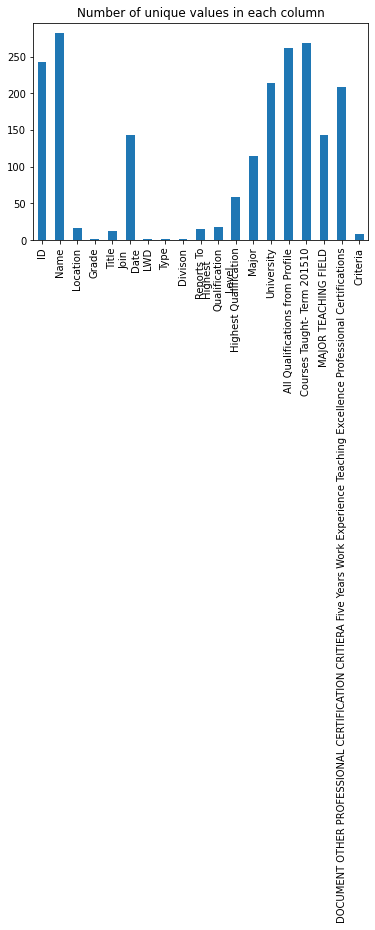

ID                                                                                                                               243
Name                                                                                                                             282
Location                                                                                                                          16
Grade                                                                                                                              2
Title                                                                                                                             12
Join\nDate                                                                                                                       143
LWD                                                                                                                                2
Type                                                                 

In [366]:
# Display the number of unique values in each column
raw_df.nunique().plot(kind='bar')
pyplot.title('Number of unique values in each column')
pyplot.show()

# Display the number of unique values in each column
print(raw_df.nunique())

# Display the unique values and their frequencies
for column in raw_df.select_dtypes(include=['object']).columns:
    print(column)
    print(raw_df[column].value_counts())
    print()

# Seems like a lot of typos, or inconsistent values
# Could likely clean these up with some simple string manipulation


# Data Cleaning

- Drop unneeded columns
- Remove all newlines to clean up messy strings
- Rename columns
- Correct Data Types

In [367]:
# Initialise the clean dataframe   
clean_df = raw_df

# Drop all uneeded columns
# ID is missing 40 values, has a number of values that seem incorrect
# This would be problematic and further data would be needed to fix this if the table was to be joined to other datasets
# However, as there is no need for this column we will drop it
clean_df = clean_df.drop(columns=['ID'])

In [368]:
# Remove all newlines from the data, and replace with a space
clean_df = clean_df.replace('\n',' ', regex=True)

# remove all newlines from the headers, and replace with a space
clean_df.columns = clean_df.columns.str.replace('\n', ' ')

In [369]:
# Column "LWD" is confising as it is not immediately clear what it stands for
# We will rename this column to "Last Working Date"
clean_df = clean_df.rename(columns={'LWD': 'Last Working Date'})

# Column "Type" is confusing as it is not immediately clear what it stands for
# We will rename this column to "Employment Type"
clean_df = clean_df.rename(columns={'Type': 'Employment Type'})

# Column "MAJOR TEACHING FIELD" is not consistent with casing, and irritating
# We will rename this column to "Major Teaching Field"
clean_df = clean_df.rename(columns={'MAJOR TEACHING FIELD': 'Major Teaching Field'})
 
# Column "DOCUMENT OTHER PROFESSIONAL CERTIFICATION CRITIERA Five Years Work Experience Teaching Excellence Professional Certifications" is a very confusing column name
# Data appears to be related to work experience, and other professional certifications
# However, the column name is very confusing
# We will rename this column to "Work Experience"
clean_df = clean_df.rename(columns={'DOCUMENT OTHER PROFESSIONAL CERTIFICATION CRITIERA Five Years Work Experience Teaching Excellence Professional Certifications': 'Work Experience'})

# Column "Divison" is spelt incorrectly
# We will rename this column to "Division"
clean_df = clean_df.rename(columns={'Divison': 'Division'})

# Column Courses Taught- Term 201510 could be neater
# We will rename this column to "Courses Taught - Term 201510"
clean_df = clean_df.rename(columns={'Courses Taught- Term 201510': 'Courses Taught - Term 201510'})

In [370]:
# remove all NaN and replace with empty string
clean_df = clean_df.replace(numpy.nan, '', regex=True)

In [371]:
# Configure correct data types
clean_df['Name'] = clean_df['Name'].astype('string')
clean_df['Location'] = clean_df['Location'].astype('string')
clean_df['Grade'] = clean_df['Grade'].astype('string')
clean_df['Title'] = clean_df['Title'].astype('string')
clean_df['Join Date'] = pandas.to_datetime(clean_df['Join Date'], format='%d-%b-%y')
clean_df['Last Working Date'] = pandas.to_datetime(clean_df['Last Working Date'], format='%d-%b-%y')
clean_df['Employment Type'] = clean_df['Employment Type'].astype('string')
clean_df['Division'] = clean_df['Division'].astype('string')
clean_df['Reports To'] = clean_df['Reports To'].astype('string')
clean_df['Highest Qualification Level'] = clean_df['Highest Qualification Level'].astype('string')
clean_df['Highest Qualification'] = clean_df['Highest Qualification'].astype('string')
clean_df['Major'] = clean_df['Major'].astype('string')
clean_df['University'] = clean_df['University'].astype('string')
clean_df['All Qualifications from Profile'] = clean_df['All Qualifications from Profile'].astype('string')
clean_df['Courses Taught - Term 201510'] = clean_df['Courses Taught - Term 201510'].astype('string')
clean_df['Major Teaching Field'] = clean_df['Major Teaching Field'].astype('string')
clean_df['Work Experience'] = clean_df['Work Experience'].astype('string')
clean_df['Criteria'] = clean_df['Criteria'].astype('string')

In [372]:
# Clean the text to ensure;
# 1. Ensure all test is lowercase
# 2. Remove punctuation
# 3. Remove numbers
# 4. Lemmatize the text
# 5. Remove whitespace

def clean_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    # Remove numbers
    text = re.sub(r'\d+', ' ', text)
    # Stem the text
    # stemmer = SnowballStemmer(language='english')
    # text = ' '.join([stemmer.stem(word) for word in text.split()])
    # Lemmatize the text
    lemmatizer = WordNetLemmatizer()
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split()])
    # Remove whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# clean the Title column
clean_df['Title'] = clean_df['Title'].apply(clean_text)

# clean the Highest Qualification Level column
clean_df['Highest Qualification Level'] = clean_df['Highest Qualification Level'].apply(clean_text)

# clean the Highest Qualification column
clean_df['Highest Qualification'] = clean_df['Highest Qualification'].apply(clean_text)

# Clean the Major column
clean_df['Major'] = clean_df['Major'].apply(clean_text)

# Clean the University column
clean_df['University'] = clean_df['University'].apply(clean_text)

# Clean the All Qualifications from Profile column
clean_df['All Qualifications from Profile'] = clean_df['All Qualifications from Profile'].apply(clean_text)

# Clean the Courses Taught - Term 201510 column
clean_df['Courses Taught - Term 201510'] = clean_df['Courses Taught - Term 201510'].apply(clean_text)

# Clean the Major Teaching Field column
clean_df['Major Teaching Field'] = clean_df['Major Teaching Field'].apply(clean_text)

# Clean the Work Experience column
clean_df['Work Experience'] = clean_df['Work Experience'].apply(clean_text)

# Clean the Criteria column
clean_df['Criteria'] = clean_df['Criteria'].apply(clean_text)

# Write out the clean datset to CSV
clean_df.to_csv('cleaned_dataset.csv', index=False)
